In [119]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
from group import compute_group_coverages, compute_split_coverages, compute_qr_coverages, compute_cqr_coverages
from Synthetic_data_generation import get_groups, generate_group_synthetic_data
from group import compute_group_coverages, compute_split_coverages


In [121]:
def run_group_synthetic_trial(n, x_std, y_std, d, std_dev_list, theta, n_test, n_cal, n_groups, alpha, exact=True):
    x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_group_synthetic_data(
        n, x_std, y_std, d, std_dev_list, theta, n_test, n_cal, n_groups
    )

    groups_train = get_groups(x_train_final[:,0:n_groups])
    groups_calib = get_groups(x_calib[:,0:n_groups])
    groups_test = get_groups(x_test[:,0:n_groups])
    
    groups_train_joined = np.vstack([groups_train,groups_calib])
    y_train_joined = np.concatenate((y_train_final,y_calib))
    
    adaptive_coverages = compute_group_coverages(
        groups_train_joined, y_train_joined, y_test, groups_test, groups_test[0:n_test], alpha, exact = exact
    )
    
    qr_coverages = compute_qr_coverages(
        groups_train_joined, groups_test, y_train_joined, y_test, alpha
    )

    cqr_coverages = compute_cqr_coverages(
        groups_train, groups_calib, groups_test, y_train_final, y_calib, y_test, alpha
    )

    adapt_cover = pd.Series(adaptive_coverages)
    qr_cover = pd.Series(qr_coverages)
    cqr_cover = pd.Series(cqr_coverages)

    df = pd.concat([adapt_cover, qr_cover, cqr_cover], keys=["adaptive", "qr", "cqr"], axis=1).reset_index()
    return df


In [127]:
df = pd.DataFrame()
ntrials = 100
alpha = 0.7
n_train = 50
n_cal = 50
n_test = 100
n = n_train + n_cal + n_test

# Parameters for data generation 
x_std = 0.1
y_std = 0.25
n_groups = 10
d = n_groups + 5 # choose d > n_groups

std_dev_list = np.array([20,0.01,20,1,5] + [1.0]*5 ) ## must be of length n_groups

theta = np.random.normal(loc=np.zeros(d), scale=x_std)
for i in range(ntrials):
    append_df = run_group_synthetic_trial(n, x_std, y_std, d, std_dev_list, theta, n_test, n_cal, n_groups, alpha=alpha)
    append_df['trial'] = i
    df = pd.concat([df, append_df])


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 74.81it/s]


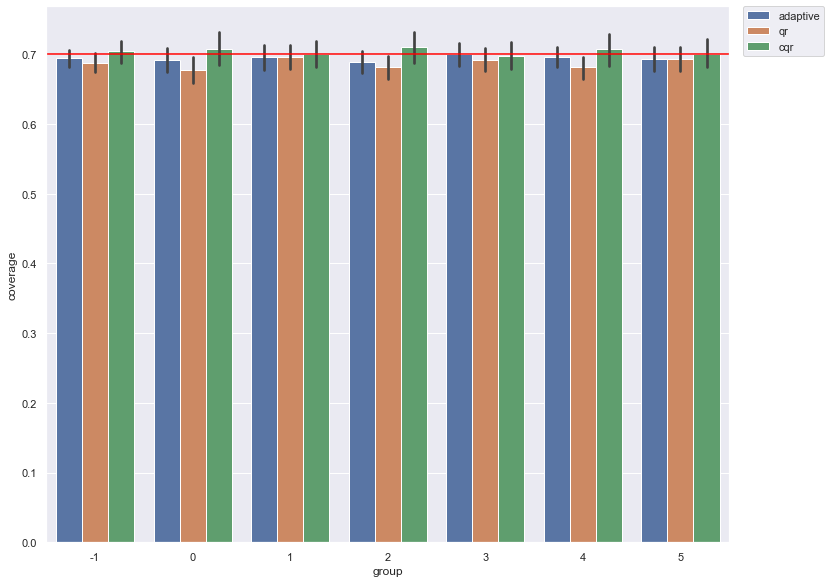

In [129]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

melted_df = pd.melt(df, id_vars=["index"], value_vars=["adaptive", "qr", "cqr"])
melted_df = melted_df.rename(columns={"index": "group", "value": "coverage"})
melted_df = melted_df[melted_df["group"] <=5]

fig = sns.barplot(melted_df, 
            x="group", y="coverage", hue="variable")
fig.axhline(alpha,color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

     group  variable  coverage
6       -1  adaptive      0.70
13      -1  adaptive      0.58
20      -1  adaptive      0.71
27      -1  adaptive      0.66
34      -1  adaptive      0.63
..     ...       ...       ...
671     -1  adaptive      0.66
678     -1  adaptive      0.67
685     -1  adaptive      0.70
692     -1  adaptive      0.62
699     -1  adaptive      0.69

[100 rows x 3 columns]


0.66

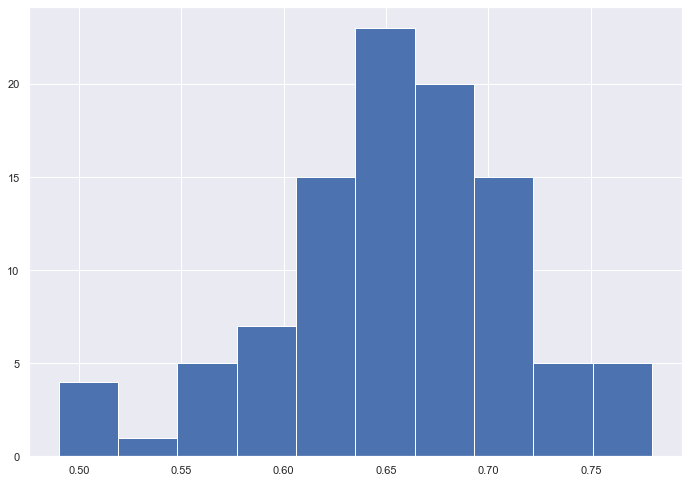

In [115]:
df2 = df[df["index"] <=5]

melted_df = pd.melt(df2, id_vars=["index"], value_vars=["adaptive", "qr", "cqr"])
melted_df = melted_df.rename(columns={"index": "group", "value": "coverage"})
melted_df = melted_df[melted_df["group"] <=5]

df3 = melted_df[melted_df["group"] == -1]
df3 = df3[df3["variable"] == "adaptive"]
print(df3)
plt.hist(df3["coverage"])
np.quantile(df3["coverage"],0.5)